# Results of Simulation in the Torus

In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd()))
import pickle 
import numpy as np
import pandas as pd
from pyfrechet.metric_spaces import MetricData, Sphere, Torus

import matplotlib.pyplot as plt
import seaborn as sns

import geomstats.visualization as visualization

INFO: Using numpy backend


In [2]:
coverages=[]
alpha=0.05
M=Torus(2)

for file in os.listdir(os.path.join(os.getcwd(), 'results')):
    infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
    result=pickle.load(infile)

    Dalpha=np.percentile(result['oob_errors'], (1-alpha)*100)
    coverages.append(np.mean(M.d(result['test_predictions'], 
                                 result['y_test_data']) <= Dalpha))

    infile.close()

In [3]:
print(len(coverages))
print(np.mean(coverages))

2800
0.9195642857142856


In [4]:
results=[]

for file in os.listdir(os.path.join(os.getcwd(), 'results')):
    infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
    result=pickle.load(infile)

    results.append(result)

    infile.close()

len(results)

2800

In [5]:
sigmas=[0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5]

def coverage_results(sigmas: list, sign_level: float=0.05) -> pd.DataFrame:
    
    coverage_df=pd.DataFrame(columns=['sample_index', 'train_size', 'sigma', 'coverage', 'OOB_quantile'])

    for file in os.listdir(os.path.join(os.getcwd(), 'results')):
        infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
        result=pickle.load(infile)
        infile.close()

        Dalpha=np.percentile(result['oob_errors'], (1-sign_level)*100)
        coverage_df=pd.concat([coverage_df, 
                               pd.DataFrame({'sample_index': int(file.split('_')[1][4:]),
                                             'train_size': int(file.split('_')[2][1:]),
                                             'sigma': sigmas[int(file.split('_')[3][5:])-1],
                                             'coverage': np.mean(M.d(result['test_predictions'], result['y_test_data']) <= Dalpha),
                                             'OOB_quantile': Dalpha}, index=pd.RangeIndex(0,1))], 
                                ignore_index=True)
        
    coverage_df['train_size']=coverage_df['train_size'].astype('int')
    coverage_df['sample_index']=coverage_df['sample_index'].astype('int')
        
    return coverage_df

sign_level=0.05
coverage_df=coverage_results(sigmas=sigmas, sign_level=sign_level)
print(coverage_df.info())
coverage_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sample_index  2800 non-null   int32  
 1   train_size    2800 non-null   int32  
 2   sigma         2800 non-null   float64
 3   coverage      2800 non-null   float64
 4   OOB_quantile  2800 non-null   float64
dtypes: float64(3), int32(2)
memory usage: 87.6 KB
None


,sample_index,train_size,sigma,coverage,OOB_quantile
0,100,100,0.10,0.94,0.988608
1,100,100,0.25,0.93,0.839687
2,100,100,0.50,0.93,1.445103
3,100,100,0.75,0.94,1.894211
4,100,100,1.00,0.84,2.627915
...,...,...,...,...,...
2795,9,50,0.50,0.93,1.786337
2796,9,50,0.75,0.87,2.061384
2797,9,50,1.00,0.81,2.741128
2798,9,50,1.25,0.94,3.160776


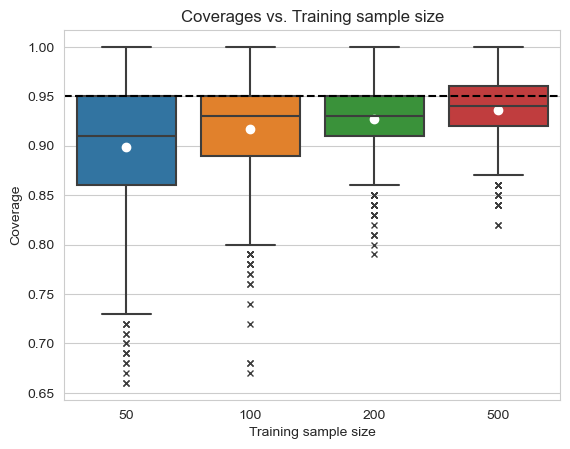

In [7]:
sns.set_style("whitegrid")

plt.figure()
sns.boxplot(data=coverage_df, x='train_size', y='coverage', hue='train_size', palette=sns.color_palette(),
            flierprops={"marker": "x"}, dodge=False)
x_ticks, _=plt.xticks()
for i in range(len(x_ticks)):
    mean=coverage_df[coverage_df.train_size==sorted(coverage_df['train_size'].unique())[i]]['coverage'].mean()
    plt.plot(x_ticks[i], mean, marker='o', color='white')
plt.axhline(y=1-sign_level, color='black', linestyle='dashed')
plt.legend().remove()
plt.title('Coverages vs. Training sample size')
plt.xlabel('Training sample size')
plt.ylabel('Coverage')
plt.show()

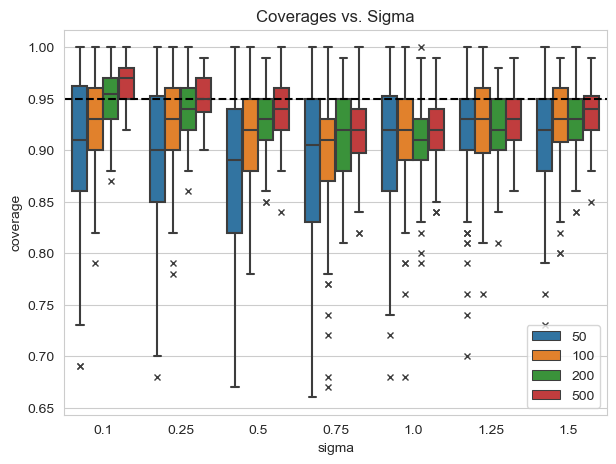

In [10]:
plt.figure(figsize=(7,5))
sns.boxplot(data=coverage_df, x='sigma', y='coverage', hue='train_size', palette=sns.color_palette(),
            flierprops={'marker':'x'})
plt.title('Coverages vs. Sigma')
plt.axhline(y=1-sign_level, color='black', linestyle='dashed')
plt.legend()#.remove()
plt.show()

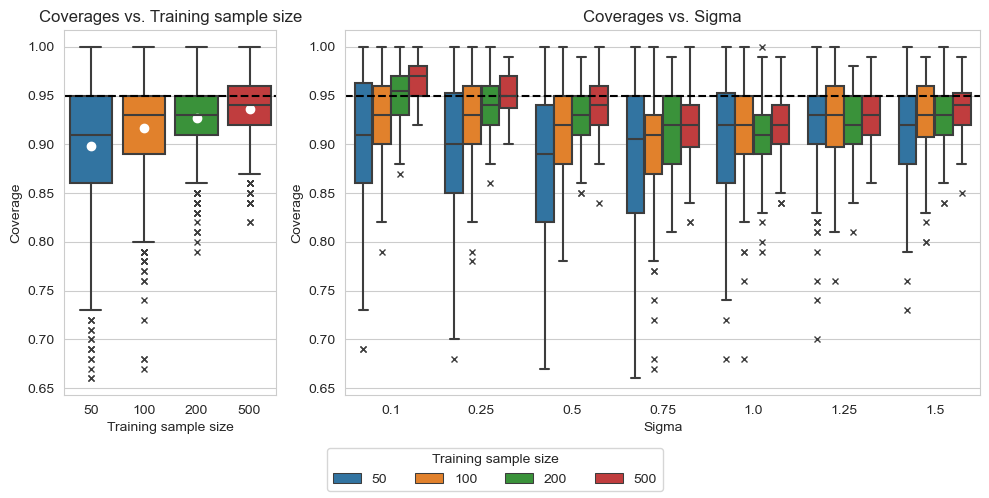

In [12]:
sns.set_style('whitegrid')
fig, axs=plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [1,3]})

sns.boxplot(data=coverage_df, x='train_size', y='coverage', hue='train_size', 
            palette=sns.color_palette(), ax=axs[0], flierprops={"marker": "x"}, dodge=False)
x_ticks=axs[0].get_xticks()
for i in range(len(x_ticks)):
    mean=coverage_df[coverage_df.train_size==sorted(coverage_df['train_size'].unique())[i]]['coverage'].mean()
    axs[0].plot(x_ticks[i], mean, marker='o', color='white')
axs[0].axhline(y=1-sign_level, color='black', linestyle='dashed')
axs[0].set_title('Coverages vs. Training sample size')
axs[0].set_xlabel('Training sample size')
axs[0].set_ylabel('Coverage')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend().remove()

sns.boxplot(data=coverage_df, x='sigma', y='coverage', hue='train_size', palette=sns.color_palette(),
            flierprops={"marker": "x"}, ax=axs[1])
axs[1].axhline(y=1-sign_level, color='black', linestyle='dashed')
axs[1].legend().remove()
axs[1].set_title('Coverages vs. Sigma')
axs[1].set_xlabel('Sigma')
axs[1].set_ylabel('Coverage')

fig.legend(labels=labels, handles=handles, loc="lower center", ncol=4,
           title='Training sample size')
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.show()

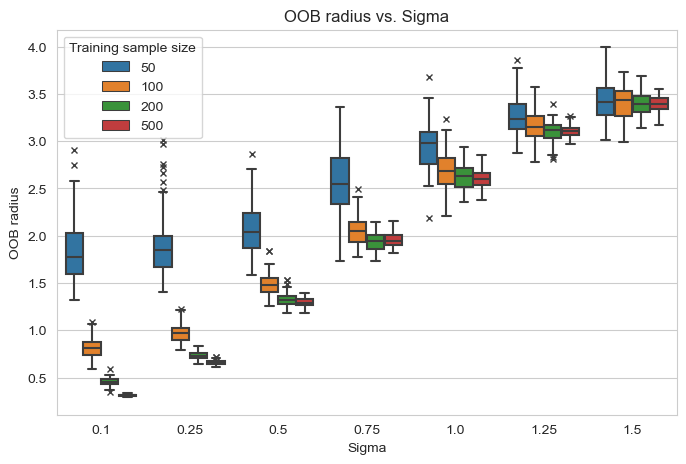

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(data=coverage_df, x='sigma', y='OOB_quantile', hue='train_size', palette=sns.color_palette(),
            flierprops={'marker':'x'})
plt.title('OOB radius vs. Sigma')
plt.xlabel('Sigma')
plt.ylabel('OOB radius')
plt.legend(title='Training sample size')#.remove()
plt.show()